# Neural Network Final Model - Cape Grim, Australia

In [9]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'CGO', 'This script is only for Cape Grim, Australia. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Cape Grim, Australia.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
292,2000-04-22 19:00:00,1.0,8.523203,-0.057781,1.445818,8.796631,12.082988,9.926284,7.664375,8.277376,...,5.150241,1.822392,-4.864377,12.000541,12.250743,-11.672159,14.628478,18.834488,6.779006,4.952369
28888,2018-06-27 07:00:00,0.0,-1.933267,-0.735687,-1.482400,-1.200745,5.430702,2.663824,4.497311,0.160042,...,-2.991365,-0.714972,-1.697335,3.044897,9.319494,28.193699,13.488809,-0.667610,-1.031223,3.190037
6444,2005-07-05 23:00:00,0.0,3.527610,-0.203457,2.309870,3.398484,3.892747,9.027521,7.576859,10.130962,...,-22.115639,-13.438131,-6.871987,9.483448,-0.388717,-6.277846,-19.844902,-24.410603,-30.439980,-14.700359
8666,2007-06-07 03:00:00,0.0,-0.056230,-1.745984,-1.644140,1.411906,13.005657,11.510984,8.267030,-2.665451,...,16.007412,14.262960,-12.580180,-2.495282,6.268112,26.307898,24.242535,11.213464,9.546362,5.132573
8855,2007-08-28 15:00:00,1.0,7.376906,1.259904,1.149825,12.364532,14.102690,13.423361,8.904636,7.246149,...,-2.000219,-8.534998,-5.712573,-3.190242,-4.698467,-4.995973,-17.938766,-8.789818,-0.488113,6.654612


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 21:00:00. Length: 1876
Val range: 2019-01-01 09:00:00 -> 2019-12-31 23:00:00. Length: 2094
Test range: 2020-01-01 01:00:00 -> 2022-12-31 07:00:00. Length: 5194


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(50,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.952
Precision on Validation Set = 0.922
Recall on Training Set = 0.984
Recall on Validation Set = 0.976
F1 Score on Training Set = 0.968
F1 Score on Validation Set = 0.948


In [6]:
# evaluating model on test set
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.936
Recall on Testing Set = 0.963
F1 Score on Testing Set = 0.950


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_CGO.joblib']

### Assessing Feature Importance

In [10]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [11]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [12]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

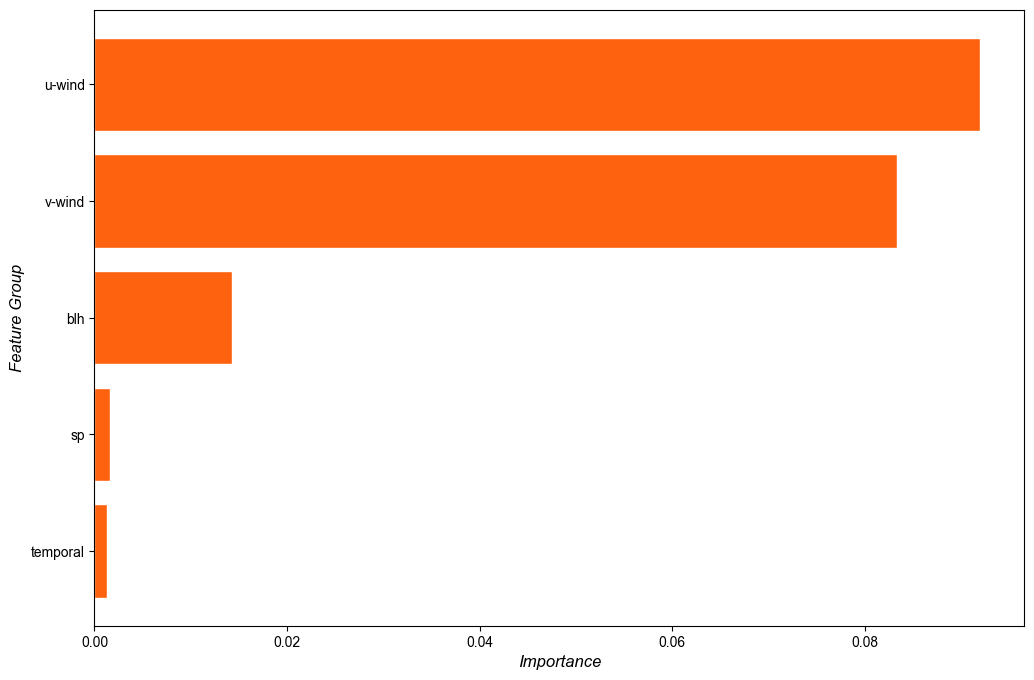

In [13]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)